### Combine LV ND datasets

The following postnatal only LV datasets will be combined
- Penn
- ENCODE v4
- Chaffin 2022
- Simonson 2023
- Heart Atlas v2 (Teichman studies: Litvinukova 2020, Kanemaru 2023)
- Reichart 2022
- Koenig 2022
- Kuppe 2022
- Hill 2022
- Sim 2020

### Consistent metadata across studies

We will keep the follow metadata (per cell) from each of the datasets

1. Donor id
2. Donor age
3. Donor sex
4. Technology used for library generation 
5. Cell or nuclei (should all be nuclei only)
6. Region (e.g. chamber such as LV)
7. Study
8. cell_type annotation (original annotation from each study, or our annotations for Penn and ENCODE v4 dataset)
9. consistent_cell_type (annotation from each study, but made consistent across all studies)

### Barcode and sample_id 

- Make sure that the original cell barcode information is retained, as this is useful for the Multiome data
- Create a sample_id as well as donor_id, as for some donor_ids, there are multiple samples (e.g. Penn and Heart Atlas v2 dataset)

#### Import libraries

In [1]:
import scanpy as sc
import anndata as adata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad
from collections import Counter
import seaborn as sns
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import re
import gc
from adjustText import adjust_text
from sklearn.mixture import GaussianMixture

In [2]:
metadata_to_keep = ["age", 
                    "donor_id", 
                    "sex", 
                    "region", 
                    "cell_type",
                    "consistent_cell_type",
                    "study", 
                    "technology", 
                    "cell_or_nuclei"]

#### Make sure to also retain the barcode information, and make donor_id + barcode as the index

### Sequentially load each of the datasets 
1. Confirm that the counts are the RAW counts (not normalized)

In [3]:
def confirm_raw_counts(adata):
    """
    Check if every value in adata.X.sum(axis=1), the sum of counts across all genes per cell, is an integer.   

    Parameters:
    adata (AnnData): The AnnData object containing the data matrix (adata.X).

    Returns:
    bool: True if all sums are integers, False otherwise.
    """
    # Sum across rows (axis=1), which correspond to the genes
    sums = adata.X.sum(axis=1)
    
    # Check if all sums are integers by comparing them to their rounded versions
    return np.all(np.equal(sums, np.round(sums)))

## LV ND datasets

#### Penn dataset

In [4]:
%%time
Penn_adata = sc.read_h5ad("../internal_datasets/postnatal_datasets/combined_analysis/processed_Penn_ND.h5ad")
Penn_adata.X = Penn_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Penn_adata)) )
Penn_adata.obs = Penn_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 822 ms, sys: 2 s, total: 2.82 s
Wall time: 4.08 s


In [5]:
Penn_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,
K1545-LV-run123:AAAAAATAGTCG,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei
K1545-LV-run123:AAAAAGACGACC,44,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei
K1545-LV-run123:AAAAAGGATCTC,44,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei
K1545-LV-run123:AAAAATGAAGTT,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei
K1545-LV-run123:AAAAATTAATGG,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei


In [6]:
# create a sample_id column, as donor_ids can have multiple sample_ids
Penn_adata.obs['sample_id'] = Penn_adata.obs_names.str.split(":").str[0]
Penn_adata.obs['barcode'] = Penn_adata.obs_names.str.split(":").str[1]

In [7]:
Penn_adata.obs_names = Penn_adata.obs['sample_id'].astype(str) + ":" + Penn_adata.obs['barcode'].astype(str)

In [8]:
Counter(Penn_adata.obs_names).most_common(1)[0]

('K1545-LV-run123:AAAAAATAGTCG', 1)

In [9]:
Penn_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
K1545-LV-run123:AAAAAATAGTCG,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAATAGTCG
K1545-LV-run123:AAAAAGACGACC,44,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGACGACC
K1545-LV-run123:AAAAAGGATCTC,44,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGGATCTC
K1545-LV-run123:AAAAATGAAGTT,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATGAAGTT
K1545-LV-run123:AAAAATTAATGG,44,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATTAATGG


#### ENCODE dataset

In [10]:
%%time
ENCODE_adata = sc.read_h5ad("../external_datasets/ENCODE_v4/post_processing_ENCODE.h5ad")
print("All raw counts?: " + str (confirm_raw_counts(ENCODE_adata)) )
ENCODE_adata.obs = ENCODE_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 4.45 s, sys: 24 s, total: 28.5 s
Wall time: 44.6 s


In [11]:
ENCODE_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
ENCSR906MRL:AAACAGCCAAATTCGT,44,ENCSR906MRL,male,LV,Atrial CM,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCSR906MRL:AAACAGCCAATTAGGA,44,ENCSR906MRL,male,LV,CM-1,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCSR906MRL:AAACAGCCAATTGAAG,44,ENCSR906MRL,male,LV,CM-3,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCSR906MRL:AAACAGCCACAATTAC,44,ENCSR906MRL,male,LV,CM-2,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei
ENCSR906MRL:AAACAGCCACCGGTAT,44,ENCSR906MRL,male,LV,Atrial CM,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei


In [12]:
ENCODE_adata.obs['barcode'] = ENCODE_adata.obs_names.str.split(":").str[1]

In [13]:
ENCODE_adata.obs_names = ENCODE_adata.obs['donor_id'].astype(str) + ":" + ENCODE_adata.obs['barcode'].astype(str)

In [14]:
Counter(ENCODE_adata.obs_names).most_common(1)[0]

# add sample_id, which is same as donor_id
ENCODE_adata.obs['sample_id'] = ENCODE_adata.obs['donor_id']

In [15]:
ENCODE_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
ENCSR906MRL:AAACAGCCAAATTCGT,44,ENCSR906MRL,male,LV,Atrial CM,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCAAATTCGT,ENCSR906MRL
ENCSR906MRL:AAACAGCCAATTAGGA,44,ENCSR906MRL,male,LV,CM-1,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCAATTAGGA,ENCSR906MRL
ENCSR906MRL:AAACAGCCAATTGAAG,44,ENCSR906MRL,male,LV,CM-3,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCAATTGAAG,ENCSR906MRL
ENCSR906MRL:AAACAGCCACAATTAC,44,ENCSR906MRL,male,LV,CM-2,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCACAATTAC,ENCSR906MRL
ENCSR906MRL:AAACAGCCACCGGTAT,44,ENCSR906MRL,male,LV,Atrial CM,Cardiomyocyte,ENCODE v4 (Snyder),Multiome-v1,Nuclei,AAACAGCCACCGGTAT,ENCSR906MRL


#### Teichman datasets

In [16]:
%%time
Teichman_adata = sc.read_h5ad("../external_datasets/Heart_Atlas_v2/processed_LV_all.h5ad")
print("All raw counts?: " + str (confirm_raw_counts(Teichman_adata)) )

# include sample_id
Teichman_adata.obs = Teichman_adata.obs[metadata_to_keep + ["sample_id"]]

All raw counts?: True
CPU times: user 944 ms, sys: 2.41 s, total: 3.35 s
Wall time: 4.17 s


In [17]:
Teichman_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id
sample_id_plus_barcode,,,,,,,,,,
HCAHeart7664652:AGCCTAACAATCCGAT-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652
HCAHeart7664652:CGGGTCATCTAAGCCA-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652
HCAHeart7664652:GTCAAGTTCACAAACC-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652
HCAHeart7664652:TACAGTGGTGATAAAC-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652
HCAHeart7664652:CTAACTTGTATTCGTG-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652


In [18]:
Counter(Teichman_adata.obs_names).most_common(1)[0]

('HCAHeart7664652:AGCCTAACAATCCGAT-1', 1)

In [19]:
Teichman_adata.obs['barcode'] = Teichman_adata.obs_names.str.split(":").str[-1]

In [20]:
Teichman_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
sample_id_plus_barcode,,,,,,,,,,,
HCAHeart7664652:AGCCTAACAATCCGAT-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652,AGCCTAACAATCCGAT-1
HCAHeart7664652:CGGGTCATCTAAGCCA-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652,CGGGTCATCTAAGCCA-1
HCAHeart7664652:GTCAAGTTCACAAACC-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652,GTCAAGTTCACAAACC-1
HCAHeart7664652:TACAGTGGTGATAAAC-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652,TACAGTGGTGATAAAC-1
HCAHeart7664652:CTAACTTGTATTCGTG-1,52.5,D1-Nuclei_3prime-v2,female,LV,Ventricular Cardiomyocyte,Cardiomyocyte,Litvinukova 2020,3prime-v2,Nuclei,HCAHeart7664652,CTAACTTGTATTCGTG-1


#### Chaffin et al. 2022

In [21]:
%%time
Chaffin_adata = sc.read_h5ad("../external_datasets/Chaffin_et_al_2022/processed_Chaffin_ND.h5ad")
Chaffin_adata.X = Chaffin_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Chaffin_adata)) )
Chaffin_adata.obs = Chaffin_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 1.21 s, sys: 6.24 s, total: 7.45 s
Wall time: 18 s


In [22]:
Chaffin_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
TTCTTCCGTTCAACGT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
CATCCACCATCTAACG-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
ACCCAAACAGCTAACT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
AAGGAATCAACTGGTT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei
TACCCGTAGCGTGCTC-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei


In [23]:
Chaffin_adata.obs['barcode'] = Chaffin_adata.obs_names

In [24]:
Chaffin_adata.obs_names = Chaffin_adata.obs['donor_id'].astype(str) + ":" + Chaffin_adata.obs['barcode'].astype(str)

In [25]:
Counter(Chaffin_adata.obs_names).most_common(1)[0]

Chaffin_adata.obs['sample_id'] = Chaffin_adata.obs['donor_id']

In [26]:
Chaffin_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P1622:TTCTTCCGTTCAACGT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,TTCTTCCGTTCAACGT-1-0,P1622
P1622:CATCCACCATCTAACG-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,CATCCACCATCTAACG-1-0,P1622
P1622:ACCCAAACAGCTAACT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,ACCCAAACAGCTAACT-1-0,P1622
P1622:AAGGAATCAACTGGTT-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,AAGGAATCAACTGGTT-1-0,P1622
P1622:TACCCGTAGCGTGCTC-1-0,56.0,P1622,male,LV,Cardiomyocyte_I,Cardiomyocyte,Chaffin 2022,3prime-v3,Nuclei,TACCCGTAGCGTGCTC-1-0,P1622


#### Simonson et al. 2023

In [27]:
%%time
# read in the entire dataset
Simonson_adata = sc.read_h5ad("../external_datasets/Simonson_et_al_2023/processed_Simonson_ND.h5ad")
Simonson_adata.X = Simonson_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Simonson_adata)) )
Simonson_adata.obs = Simonson_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 434 ms, sys: 1.55 s, total: 1.98 s
Wall time: 5.7 s


In [28]:
Simonson_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
ACCAACAAGGGTTTCT-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
ATTCACTTCCCGAGGT-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
ATGCATGCACGCTTAA-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
CAACCTCTCAGACCCG-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei
CTCCCAAGTTCGTAAC-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei


In [29]:
Simonson_adata.obs['barcode'] = Simonson_adata.obs_names

In [30]:
Simonson_adata.obs_names = Simonson_adata.obs['donor_id'].astype(str) + ":" + Simonson_adata.obs['barcode'].astype(str)

In [31]:
Counter(Simonson_adata.obs_names).most_common(1)[0]

Simonson_adata.obs['sample_id'] = Simonson_adata.obs['donor_id']

In [32]:
Simonson_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P1452:ACCAACAAGGGTTTCT-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,ACCAACAAGGGTTTCT-1-1,P1452
P1452:ATTCACTTCCCGAGGT-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,ATTCACTTCCCGAGGT-1-1,P1452
P1452:ATGCATGCACGCTTAA-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,ATGCATGCACGCTTAA-1-1,P1452
P1452:CAACCTCTCAGACCCG-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,CAACCTCTCAGACCCG-1-1,P1452
P1452:CTCCCAAGTTCGTAAC-1-1,47,P1452,female,LV,Cardiomyocyte I,Cardiomyocyte,Simonson 2023,3prime-v3,Nuclei,CTCCCAAGTTCGTAAC-1-1,P1452


#### Koenig et al. 2022

In [33]:
%%time
Koenig_adata = sc.read_h5ad("../external_datasets/Koenig_et_al_2022/processed_Koenig_ND.h5ad")
Koenig_adata.X = Koenig_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Koenig_adata)) )
Koenig_adata.obs = Koenig_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 965 ms, sys: 5.58 s, total: 6.54 s
Wall time: 8.85 s


In [34]:
Koenig_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,
H_ZC-11-292_TAAGTGCAGCAGGTCA,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-11-292_ACAGCCGGTCATACTG,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-11-292_AACTCCCTCTTTAGTC,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-11-292_CTGATCCGTTATTCTC,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei
H_ZC-11-292_GCACTCTTCTCGTATT,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei


In [35]:
Koenig_adata.obs['barcode'] = Koenig_adata.obs_names.str.split("_").str[-1]

In [36]:
Koenig_adata.obs_names = Koenig_adata.obs['donor_id'].astype(str) + ":" + Koenig_adata.obs['barcode'].astype(str)

In [37]:
Counter(Koenig_adata.obs_names).most_common(1)[0]

Koenig_adata.obs['sample_id'] = Koenig_adata.obs['donor_id']

In [38]:
Koenig_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
H_ZC-11-292:TAAGTGCAGCAGGTCA,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei,TAAGTGCAGCAGGTCA,H_ZC-11-292
H_ZC-11-292:ACAGCCGGTCATACTG,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei,ACAGCCGGTCATACTG,H_ZC-11-292
H_ZC-11-292:AACTCCCTCTTTAGTC,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei,AACTCCCTCTTTAGTC,H_ZC-11-292
H_ZC-11-292:CTGATCCGTTATTCTC,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei,CTGATCCGTTATTCTC,H_ZC-11-292
H_ZC-11-292:GCACTCTTCTCGTATT,68,H_ZC-11-292,male,LV,Endocardium,Endocardial,Koenig 2022,5prime-v1,Nuclei,GCACTCTTCTCGTATT,H_ZC-11-292


#### Reichart et al. 2022

In [39]:
%%time
# read in the entire dataset
Reichart_adata = sc.read_h5ad("../external_datasets/Reichart_et_al_2022/processed_Reichart_ND.h5ad")
Reichart_adata.X = Reichart_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Reichart_adata)) )
Reichart_adata.obs = Reichart_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 400 ms, sys: 1.46 s, total: 1.86 s
Wall time: 2.79 s


In [40]:
Reichart_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
221966,74.5,ReichartH53,male,LV,endothelial cell,Endothelial,Reichart 2022,3prime-v3,Nuclei
221967,74.5,ReichartH53,male,LV,fibroblast of cardiac tissue,Fibroblast,Reichart 2022,3prime-v3,Nuclei
221968,74.5,ReichartH53,male,LV,mural cell,Pericyte,Reichart 2022,3prime-v3,Nuclei
221969,74.5,ReichartH53,male,LV,cardiac muscle cell,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei
221970,74.5,ReichartH53,male,LV,endothelial cell,Endothelial,Reichart 2022,3prime-v3,Nuclei


In [41]:
# not actually a barcode, seems that they dropped this information
Reichart_adata.obs['barcode'] = Reichart_adata.obs_names
Reichart_adata.obs_names = Reichart_adata.obs.donor_id.astype(str) + ":" + Reichart_adata.obs_names.astype(str)

In [42]:
Counter(Reichart_adata.obs_names).most_common(1)[0]
Reichart_adata.obs['sample_id'] = Reichart_adata.obs['donor_id']

In [43]:
Reichart_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
ReichartH53:221966,74.5,ReichartH53,male,LV,endothelial cell,Endothelial,Reichart 2022,3prime-v3,Nuclei,221966,ReichartH53
ReichartH53:221967,74.5,ReichartH53,male,LV,fibroblast of cardiac tissue,Fibroblast,Reichart 2022,3prime-v3,Nuclei,221967,ReichartH53
ReichartH53:221968,74.5,ReichartH53,male,LV,mural cell,Pericyte,Reichart 2022,3prime-v3,Nuclei,221968,ReichartH53
ReichartH53:221969,74.5,ReichartH53,male,LV,cardiac muscle cell,Cardiomyocyte,Reichart 2022,3prime-v3,Nuclei,221969,ReichartH53
ReichartH53:221970,74.5,ReichartH53,male,LV,endothelial cell,Endothelial,Reichart 2022,3prime-v3,Nuclei,221970,ReichartH53


#### Kuppe et al. 2022

In [44]:
%%time
# read in the entire dataset
Kuppe_adata = sc.read_h5ad("../external_datasets/Kuppe_et_al_2022/02_processed_Kuppe_ND.h5ad")
Kuppe_adata.X = Kuppe_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Kuppe_adata)) )
Kuppe_adata.obs = Kuppe_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 427 ms, sys: 1.4 s, total: 1.82 s
Wall time: 2.26 s


In [45]:
Kuppe_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
index,,,,,,,,,
AAACCCACAAAGGAGA-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,44,P1,male,LV,Fibroblast,Fibroblast,Kuppe 2022,3prime-v3,Nuclei
AAACCCACAGAGATGC-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei
AAACCCAGTAACGGTG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei
AAACCCAGTCCAGAAG-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,44,P1,male,LV,Fibroblast,Fibroblast,Kuppe 2022,3prime-v3,Nuclei
AAACCCAGTCGTCGGT-1_1_1_1_1_1_1_1_1_1_1_1_1_1_1,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei


In [46]:
Kuppe_adata.obs_names = Kuppe_adata.obs_names.str.split("-").str[0]

In [47]:
Kuppe_adata.obs_names = Kuppe_adata.obs.donor_id.astype(str) + ":" + Kuppe_adata.obs_names.astype(str)

In [48]:
Kuppe_adata.obs['barcode'] = Kuppe_adata.obs_names.str.split(":").str[-1]

In [49]:
Counter(Kuppe_adata.obs_names).most_common(1)[0]
Kuppe_adata.obs['sample_id'] = Kuppe_adata.obs['donor_id']

In [50]:
Kuppe_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,barcode,sample_id
P1:AAACCCACAAAGGAGA,44,P1,male,LV,Fibroblast,Fibroblast,Kuppe 2022,3prime-v3,Nuclei,AAACCCACAAAGGAGA,P1
P1:AAACCCACAGAGATGC,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCACAGAGATGC,P1
P1:AAACCCAGTAACGGTG,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCAGTAACGGTG,P1
P1:AAACCCAGTCCAGAAG,44,P1,male,LV,Fibroblast,Fibroblast,Kuppe 2022,3prime-v3,Nuclei,AAACCCAGTCCAGAAG,P1
P1:AAACCCAGTCGTCGGT,44,P1,male,LV,Cardiomyocyte,Cardiomyocyte,Kuppe 2022,3prime-v3,Nuclei,AAACCCAGTCGTCGGT,P1


#### Hill et al. 2022

#### For this dataset, we will remove the two young non-diseased donors that were also profiled in the Koenig et al. 2022 study

In [51]:
%%time
# read in the entire dataset
Hill_adata = sc.read_h5ad("../external_datasets/Hill_et_al_2022/02_processed_Hill_ND.h5ad")
Hill_adata.X = Hill_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Hill_adata)) )
Hill_adata.obs = Hill_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 424 ms, sys: 1.13 s, total: 1.55 s
Wall time: 2.02 s


In [53]:
Counter(Hill_adata.obs.donor_id)

Counter({'TWCM-13-198': 13130, 'UK2': 12234, 'UK1': 5158})

In [54]:
Hill_adata = Hill_adata[Hill_adata.obs.donor_id != "TWCM-13-198"].copy()

In [55]:
Hill_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
NAME,,,,,,,,,
UK_Ctrl_1_1_GAACACTAGCACCCAC-1,9,UK1,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
UK_Ctrl_2_3_CCTCACAAGTGAGCCA-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
UK_Ctrl_2_1_CACGAATAGACTCAAA-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
UK_Ctrl_2_2_AACACACGTAAGATTG-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei
UK_Ctrl_1_2_TTATTGCTCGCGTGAC-1,9,UK1,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei


In [56]:
Hill_adata.obs['sample_id'] = Hill_adata.obs['donor_id']
Hill_adata.obs['barcode'] = Hill_adata.obs_names.str.split("_").str[-1]

In [57]:
Counter(Hill_adata.obs_names).most_common(1)[0]

('UK_Ctrl_1_1_GAACACTAGCACCCAC-1', 1)

In [58]:
Hill_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
NAME,,,,,,,,,,,
UK_Ctrl_1_1_GAACACTAGCACCCAC-1,9,UK1,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,UK1,GAACACTAGCACCCAC-1
UK_Ctrl_2_3_CCTCACAAGTGAGCCA-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,UK2,CCTCACAAGTGAGCCA-1
UK_Ctrl_2_1_CACGAATAGACTCAAA-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,UK2,CACGAATAGACTCAAA-1
UK_Ctrl_2_2_AACACACGTAAGATTG-1,3,UK2,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,UK2,AACACACGTAAGATTG-1
UK_Ctrl_1_2_TTATTGCTCGCGTGAC-1,9,UK1,female,LV,CM,Cardiomyocyte,Hill 2022,3prime-v3,Nuclei,UK1,TTATTGCTCGCGTGAC-1


### Sim 2020

In [59]:
%%time
# read in the entire dataset
Sim_adata = sc.read_h5ad("../external_datasets/fetal_datasets/Sim_et_al_2020/02_Sim_ND.h5ad")
Sim_adata.X = Sim_adata.layers['counts']
print("All raw counts?: " + str (confirm_raw_counts(Sim_adata)) )
Sim_adata.obs = Sim_adata.obs[metadata_to_keep]

All raw counts?: True
CPU times: user 607 ms, sys: 1.01 s, total: 1.62 s
Wall time: 2.17 s


In [60]:
Sim_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei
GSM4742855_Adult2_processed:AAACCCAAGATCGACG-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei
GSM4742855_Adult2_processed:AAACCCAAGCCACTCG-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei
GSM4742855_Adult2_processed:AAACCCAGTATCGAGG-1,42,GSM4742855_Adult2_processed,male,LV,Endothelial,Endothelial,Sim 2021,3prime-v1,Nuclei
GSM4742855_Adult2_processed:AAACCCAGTTGGATCT-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei
GSM4742855_Adult2_processed:AAACCCAGTTTCGGCG-1,42,GSM4742855_Adult2_processed,male,LV,Lymphoid,Lymphoid,Sim 2021,3prime-v1,Nuclei


In [61]:
Sim_adata.obs['sample_id'] = Sim_adata.obs['donor_id'] 
Sim_adata.obs['barcode'] = Sim_adata.obs_names.str.split(":").str[-1]

In [62]:
Counter(Sim_adata.obs_names).most_common(1)[0]

('GSM4742855_Adult2_processed:AAACCCAAGATCGACG-1', 1)

In [63]:
Sim_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
GSM4742855_Adult2_processed:AAACCCAAGATCGACG-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei,GSM4742855_Adult2_processed,AAACCCAAGATCGACG-1
GSM4742855_Adult2_processed:AAACCCAAGCCACTCG-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei,GSM4742855_Adult2_processed,AAACCCAAGCCACTCG-1
GSM4742855_Adult2_processed:AAACCCAGTATCGAGG-1,42,GSM4742855_Adult2_processed,male,LV,Endothelial,Endothelial,Sim 2021,3prime-v1,Nuclei,GSM4742855_Adult2_processed,AAACCCAGTATCGAGG-1
GSM4742855_Adult2_processed:AAACCCAGTTGGATCT-1,42,GSM4742855_Adult2_processed,male,LV,Fibroblast,Fibroblast,Sim 2021,3prime-v1,Nuclei,GSM4742855_Adult2_processed,AAACCCAGTTGGATCT-1
GSM4742855_Adult2_processed:AAACCCAGTTTCGGCG-1,42,GSM4742855_Adult2_processed,male,LV,Lymphoid,Lymphoid,Sim 2021,3prime-v1,Nuclei,GSM4742855_Adult2_processed,AAACCCAGTTTCGGCG-1


### Reformat and then combine

In [64]:
# run this so that adata won't complain
def convert_indices_to_string(adata):
    adata.obs.index = adata.obs.index.astype(str)
    adata.var.index = adata.var.index.astype(str)
    return adata

In [65]:
# Convert indices for all adata
Penn_adata = convert_indices_to_string(Penn_adata)
ENCODE_adata = convert_indices_to_string(ENCODE_adata)
Teichman_adata = convert_indices_to_string(Teichman_adata)
Chaffin_adata = convert_indices_to_string(Chaffin_adata)
Simonson_adata = convert_indices_to_string(Simonson_adata)
Koenig_adata = convert_indices_to_string(Koenig_adata)
Kuppe_adata = convert_indices_to_string(Kuppe_adata)
Reichart_adata = convert_indices_to_string(Reichart_adata)
Hill_adata = convert_indices_to_string(Hill_adata)
Sim_adata = convert_indices_to_string(Sim_adata)

### Combine the adatas together

The inner join for features (genes), rather than outer join is more appropriate as many of the datasets removed mitochondrial transcripts entirely from their analysis.

In [66]:
%%time 

# merge the adata together
all_adata = ad.concat([Penn_adata,
                       ENCODE_adata,
                       Teichman_adata,
                       Chaffin_adata, 
                       Simonson_adata, 
                       Koenig_adata, 
                       Kuppe_adata, 
                       Reichart_adata, 
                       Hill_adata, 
                       Sim_adata])
all_adata

CPU times: user 3min 30s, sys: 5min 16s, total: 8min 47s
Wall time: 8min 48s


AnnData object with n_obs × n_vars = 1608272 × 16216
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'sample_id', 'barcode'
    layers: 'counts'

In [99]:
Counter(all_adata.obs_names).most_common(1)[0]

('K1545-LV-run123:AAAAAATAGTCG', 1)

In [100]:
all_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode
K1545-LV-run123:AAAAAATAGTCG,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAATAGTCG
K1545-LV-run123:AAAAAGACGACC,44.0,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGACGACC
K1545-LV-run123:AAAAAGGATCTC,44.0,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGGATCTC
K1545-LV-run123:AAAAATGAAGTT,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATGAAGTT
K1545-LV-run123:AAAAATTAATGG,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATTAATGG


### Visualize metadata about the datasets

This is also a way to check that the metadata is consistent

#### Age representation across all datasets

In [101]:
donor_information = ( all_adata.obs.reset_index(drop = True)[["sex", "donor_id", "age", "study", "technology"]]
                     .drop_duplicates()
                     .reset_index(drop = True) )
donor_information

,sex,donor_id,age,study,technology
0,male,K1545,44.0,Penn,Dropseq
1,male,K1485,78.0,Penn,Dropseq
2,male,K1584,22.0,Penn,Dropseq
3,male,ND15755,65.0,Penn,Dropseq
4,female,ND15840,91.0,Penn,Dropseq
...,...,...,...,...,...
149,male,GSM4742862_Young3_processed,14.0,Sim 2021,3prime-v1
150,male,GSM4742860_Young1_processed,4.0,Sim 2021,3prime-v1
151,male,GSM4742856_Adult3_processed,42.0,Sim 2021,3prime-v1
152,female,GSM4742854_Adult1_processed,35.0,Sim 2021,3prime-v1


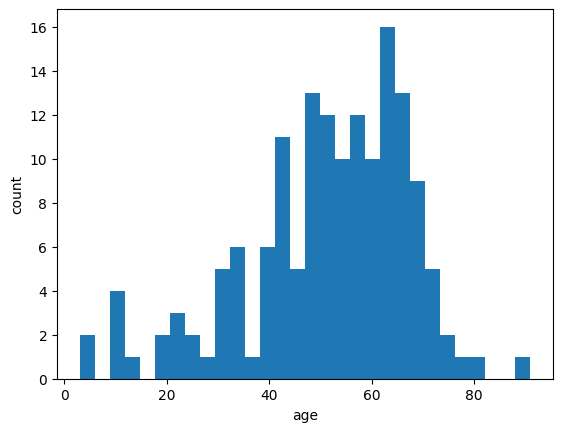

In [102]:
plt.hist(donor_information['age'], bins = 30)
plt.xlabel("age")
plt.ylabel("count")
plt.show()

In [103]:
donor_information['study'] = pd.Categorical(donor_information['study'])
donor_information['technology'] = pd.Categorical(donor_information['technology'])
donor_information['sex'] = pd.Categorical(donor_information['sex'])

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


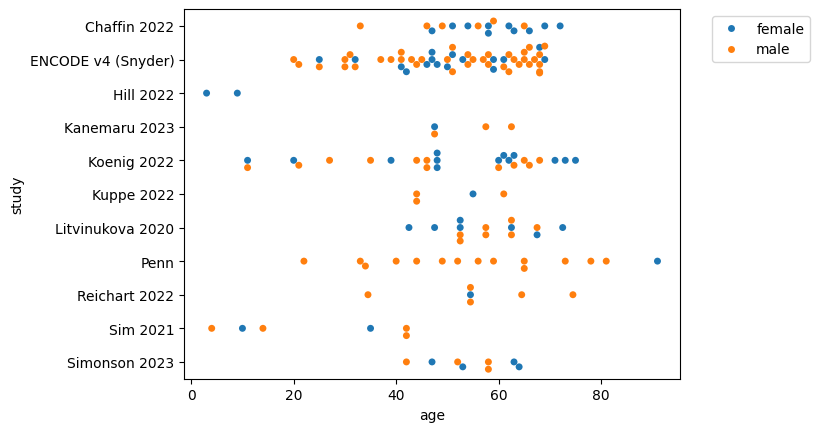

In [104]:
sns.swarmplot(data = donor_information, x='age', y='study', hue = 'sex', alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Confirm sex-specific expression
Based on the analysis of some sex-specific genes

In [105]:
metadata_at_donor_level = all_adata.obs.reset_index(drop = True)[["age", "sex", "donor_id"]].drop_duplicates()

# pseudobulk
pseudobulked_adata = sc.get.aggregate(all_adata, by=["donor_id"], func="sum")
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [106]:
# These are genes that have strong sex-specific expression
female_sex_specific_genes = ['TSIX', 'XIST']
male_sex_specific_genes = ['DDX3Y', 'EIF1AY', 'KDM5D', 'LINC00278', 'RPS4Y1',
                             'TMSB4Y', 'TTTY10', 'TTTY14', 'USP9Y', 'UTY', 'ZFY', 'ZFY-AS1']
combined_sex_specific_genes = female_sex_specific_genes + male_sex_specific_genes

In [107]:
pseudobulked_adata.X = pseudobulked_adata.layers['sum']

In [108]:
sex_specific_pseudobulked_adata = pseudobulked_adata[:, pseudobulked_adata.var.index.isin(combined_sex_specific_genes)].copy()
sex_specific_pseudobulked_adata.X = sex_specific_pseudobulked_adata.layers['sum']

In [109]:
%%time
sc.pp.normalize_total(sex_specific_pseudobulked_adata)
sc.pp.log1p(sex_specific_pseudobulked_adata)
sc.pp.scale(sex_specific_pseudobulked_adata)
sc.pp.highly_variable_genes(sex_specific_pseudobulked_adata, n_top_genes=100)
sc.tl.pca(sex_specific_pseudobulked_adata)

CPU times: user 20.2 ms, sys: 259 μs, total: 20.4 ms
Wall time: 19.6 ms


In [110]:
# add more metadata to the pseudobulked metadata
sex_specific_pseudobulked_adata.obs = sex_specific_pseudobulked_adata.obs.merge(metadata_at_donor_level, on = "donor_id", how = "inner")

#### Visualize PCA clusters in easier to edit format

In [111]:
pseudobulked_metadata = sex_specific_pseudobulked_adata.obs

In [112]:
pseudobulked_metadata['PC1'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 0]
pseudobulked_metadata['PC2'] = sex_specific_pseudobulked_adata.obsm['X_pca'][:, 1]

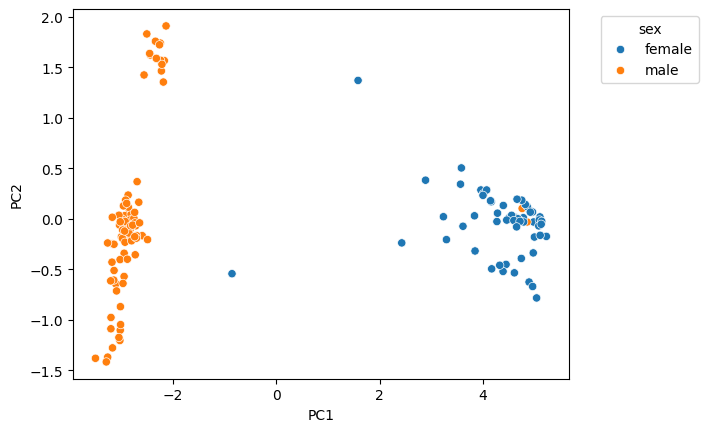

In [113]:
sns.scatterplot(data = pseudobulked_metadata,
                x = "PC1", y = "PC2", hue = "sex")
plt.legend(title='sex', bbox_to_anchor=(1.05, 1), loc='upper left')

In [114]:
# likely should be female
likely_misclassified_female_donors = pseudobulked_metadata[(pseudobulked_metadata['PC1'] > 0) & (pseudobulked_metadata['sex'] == "male")]
likely_misclassified_female_donors

,donor_id,age,sex,PC1,PC2
13,ENCSR008CVR,67.0,male,4.756016,0.102217
23,ENCSR175TRJ,61.0,male,4.851261,-0.031897
41,ENCSR485GOL,51.0,male,4.677227,-0.000200


In [115]:
# likely should be male
likely_misclassified_male_donors = pseudobulked_metadata[(pseudobulked_metadata['PC1'] < -1.5) & (pseudobulked_metadata['sex'] == "female")]
likely_misclassified_male_donors

,donor_id,age,sex,PC1,PC2


### Revise the sex metadata

ENCSR008CVR, ENCSR175TRJ, ENCSR485GOL may be misannotated as "male" when their gene expression is more consistent with "female" sex expression. We will revise the metadata as is, but this may affect sex-specific differential expression.

In [116]:
donors_to_change_to_female = likely_misclassified_female_donors['donor_id']
print(donors_to_change_to_female)

donors_to_change_to_male = likely_misclassified_male_donors['donor_id']
print(donors_to_change_to_male)

13    ENCSR008CVR
23    ENCSR175TRJ
41    ENCSR485GOL
Name: donor_id, dtype: category
Categories (154, object): ['AH1-Nuclei_Multiome-v1', 'D1-Nuclei_3prime-v2', 'D2-Nuclei_3prime-v2', 'D3-Nuclei_3prime-v2', ..., 'TWCM-13-235', 'TWCM-14-173', 'UK1', 'UK2']
Series([], Name: donor_id, dtype: category
Categories (154, object): ['AH1-Nuclei_Multiome-v1', 'D1-Nuclei_3prime-v2', 'D2-Nuclei_3prime-v2', 'D3-Nuclei_3prime-v2', ..., 'TWCM-13-235', 'TWCM-14-173', 'UK1', 'UK2'])


In [117]:
all_adata.obs.loc[all_adata.obs['donor_id'].isin(donors_to_change_to_female), 'sex'] = "female"
all_adata.obs.loc[all_adata.obs['donor_id'].isin(donors_to_change_to_male), 'sex'] = "male"

#### Save the combined adata

In [118]:
all_adata.obs['age'] = all_adata.obs['age'].astype('float')
all_adata.var_names = all_adata.var_names.astype(str)

### Add tech plus study as batch effect

In [119]:
all_adata.obs['tech_plus_study'] = all_adata.obs['technology'].astype(str) + "_" + all_adata.obs['study'].astype(str)

In [120]:
set(all_adata.obs.tech_plus_study)

{'3prime-v1_Sim 2021',
 '3prime-v2_Litvinukova 2020',
 '3prime-v3_Chaffin 2022',
 '3prime-v3_Hill 2022',
 '3prime-v3_Kuppe 2022',
 '3prime-v3_Litvinukova 2020',
 '3prime-v3_Reichart 2022',
 '3prime-v3_Simonson 2023',
 '5prime-v1_Koenig 2022',
 'Dropseq_Penn',
 'Multiome-v1_ENCODE v4 (Snyder)',
 'Multiome-v1_Kanemaru 2023'}

In [121]:
set(all_adata.obs.consistent_cell_type)

{'Adipocyte',
 'Cardiomyocyte',
 'Endocardial',
 'Endothelial',
 'Epicardial',
 'Fibroblast',
 'LEC',
 'Lymphoid',
 'Mast',
 'Myeloid',
 'Neuronal',
 'Pericyte',
 'Unclear',
 'vSMC'}

### All of these are non-diseased, so add that to the metadata

In [122]:
all_adata.obs['disease'] = "ND"
all_adata.obs['age_status'] = "postnatal"

In [123]:
all_adata.obs.head()

,age,donor_id,sex,region,cell_type,consistent_cell_type,study,technology,cell_or_nuclei,sample_id,barcode,tech_plus_study,disease,age_status
K1545-LV-run123:AAAAAATAGTCG,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAATAGTCG,Dropseq_Penn,ND,postnatal
K1545-LV-run123:AAAAAGACGACC,44.0,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGACGACC,Dropseq_Penn,ND,postnatal
K1545-LV-run123:AAAAAGGATCTC,44.0,K1545,male,LV,Fibroblast,Fibroblast,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAAGGATCTC,Dropseq_Penn,ND,postnatal
K1545-LV-run123:AAAAATGAAGTT,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATGAAGTT,Dropseq_Penn,ND,postnatal
K1545-LV-run123:AAAAATTAATGG,44.0,K1545,male,LV,Cardiomyocyte,Cardiomyocyte,Penn,Dropseq,Nuclei,K1545-LV-run123,AAAAATTAATGG,Dropseq_Penn,ND,postnatal


In [124]:
# finally, reconfirm that these are the raw counts
confirm_raw_counts(all_adata)

True

In [125]:
%%time
all_adata.write("01_combined_LV_ND.h5ad")
gc.collect()

CPU times: user 24.1 s, sys: 45.7 s, total: 1min 9s
Wall time: 1min 22s


1424